In [1]:
shape = 'Angle'
dataset = 'lasa_dataset/{shape}.mat'.format(shape=shape)
matlab_export_file = shape + '.m'
deg_p = 4
deg_f = 4
alpha_p = 1e-8
alpha_f = 1e-8
make_zero_at_end = False
tau = 0.

In [2]:
import numpy as np
import pandas as pd
import learn_vectorfield_from_data
from importlib import reload

# plotting
import matplotlib.pyplot as plt
%matplotlib inline

# logger
import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

# matlab
import matlab.engine
try:
    eng = matlab.engine.connect_matlab('shared_davisson')
except matlab.engine.EngineError:
    print('Engine already connected or not able to connect')

In [3]:
# learn the optimal contracting vector field

tracking_error, opt_vf = learn_vectorfield_from_data.learn_and_output(dataset, 
                                             matlab_export_file, 
                                             deg_p, 
                                             deg_f, 
                                             alpha_p, 
                                             alpha_f, 
                                             tau,
                                             make_zero_at_end)

Fitting a polynomial of degree 4 to lasa_dataset/Angle.mat and learning a vectorfield of degree 4 with tau = 0.0, alpha_p=1e-08, alpha_f=1e-08. make_zero_at_end=False
Optimal value: 0.04
Optimal vectorfield f(x_0, x_1) = [132236.338943025*x_0**4 + 110080.359288411*x_0**3*x_1 - 34181.9740874657*x_0**3 + 25740.6852365444*x_0**2*x_1**2 + 9.69268095459483*x_0**2*x_1 - 89.0938920636763*x_0**2 - 7395.92573694926*x_0*x_1**3 + 1532.88885678874*x_0*x_1**2 - 480.794839360226*x_0*x_1 + 6.34800355619336*x_0 + 455.941494976966*x_1**4 + 3257.42350564328*x_1**3 + 55.872359305657*x_1**2 + 0.241356873711538*x_1 + 0.0421688907708813, 134203.537838083*x_0**4 + 114233.401573667*x_0**3*x_1 + 20276.2459287119*x_0**3 + 100779.73928263*x_0**2*x_1**2 - 6925.14585223624*x_0**2*x_1 - 168.336489771709*x_0**2 - 22992.0089883945*x_0*x_1**3 + 568.913888399177*x_0*x_1**2 + 24.2338798028622*x_0*x_1 - 11.5234438443863*x_0 + 1507.14868252311*x_1**4 - 1589.54579812072*x_1**3 - 119.928582015165*x_1**2 - 0.962773843933519*

In [4]:
# load dataset

demo = eng.load(dataset)
for k, v in demo.items():
    print('Loading item', k)
    eng.workspace[k] = v

# run evaluation metrics
print('Running LfD evaluation')    
matlab_result = eng.eval("lfd_evaluation(@{shape}, demos, 0)"\
                         .format(shape=shape))
print('End evaluation')

Loading item dt
Loading item demos
Running LfD evaluation
End evaluation


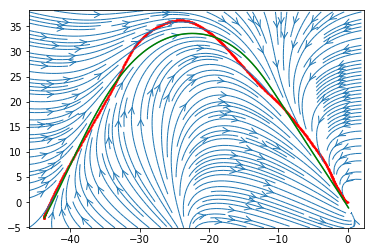

In [5]:
# visualize the vector field
def py_to_mat_array(x):
    x = list(map(list, x))
    s = str(x).replace('],', '];')
    return s

from scipy.integrate import odeint
def integrate_trajectory(f, x_0, T):
    f_t = lambda x, t: f([x])[0]
    vf_path = odeint(f_t, x_0, T, )
    return vf_path

f  = lambda x: np.array(eng.eval('{f}({x})'\
                                 .format(f=shape, 
                                x=py_to_mat_array(x))))
demo_i = np.array(demo['demos'][0]['pos'])
x_0 = demo_i[:, 0]
T = np.array(demo['demos'][0]['t']).squeeze()
vf_path = integrate_trajectory(f, x_0, T)
plt.scatter(*demo_i, s=1, c='r')
plt.plot(*vf_path.T, c='g')
limits = list(plt.xlim()) + list(plt.ylim())
learn_vectorfield_from_data.visualize_vf(f, limits)

In [6]:
# How well does the dynamical system represent the demonstrations?
keys  = 'trajectory_error velocity_error distance_to_goal'.split()
# How long does it take to hit the target
keys += 'dtwd_at_30T duration_to_goal'.split()
pd.DataFrame({k: np.array(matlab_result[k])[0] for k in keys})          

,trajectory_error,velocity_error,distance_to_goal,dtwd_at_30T,duration_to_goal
0,5.686007,12.932933,1.128121,1326.973725,2.244021
1,13.161980,20.705046,2.107570,2394.771538,2.239358
2,9.897171,16.083570,2.169764,2666.597815,2.227830
3,14.734999,21.768222,2.175795,2886.686379,2.245253
4,11.941769,18.780096,2.075289,3689.888455,2.167090
5,11.968464,18.698521,2.149964,2470.058662,2.178502
6,10.643396,14.700255,2.159182,3299.655161,2.211199


In [7]:
grid_dtwd = np.array(matlab_result['grid_dtwd'])
columns = ['demo_{i}'.format(i=i) for i in range(grid_dtwd.shape[1])]
rows = ['x0_{i}'.format(i=i) for i in range(grid_dtwd.shape[0])]
print('grid_dtwd')
pd.DataFrame(grid_dtwd, columns=columns, index=rows).round(1)

grid_dtwd


,demo_0,demo_1,demo_2,demo_3,demo_4,demo_5,demo_6
x0_0,1113.3,2518.1,2669.6,2892.1,4025.9,2778.7,3570.5
x0_1,2640.6,3215.0,3185.4,3552.1,3765.3,2856.6,3565.7
x0_2,5370.4,5365.7,4588.9,5179.1,4722.3,4338.1,4757.0
x0_3,9518.2,9594.9,6337.2,7737.7,6818.2,7019.8,7745.0
x0_4,2581.0,3846.5,3290.5,4035.0,4814.5,3732.9,4541.8
x0_5,4841.3,6045.8,5116.9,6247.1,6982.6,5768.1,6257.6
x0_6,6879.8,7778.1,6016.7,7683.3,7789.4,6896.6,7365.9
x0_7,10182.0,10588.7,6832.6,8746.3,8141.2,7992.8,8985.4
x0_8,28709.1,30054.7,29247.6,31957.4,31945.7,30272.9,28754.5
x0_9,18533.2,19246.8,18768.6,20864.3,21403.3,19739.5,18382.6
